In [0]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html 

In [0]:
!pip install fastai

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

In [0]:
import psutil
import humanize
import os
import GPUtil as GPU

In [0]:
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

In [0]:
# import libraries 
import fastai 
from fastai import * 
from fastai.text import * 
import pandas as pd 
import numpy as np 
from functools import partial 
import io 
import os
import sqlite3 as sl
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive, files

In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd 'drive/My Drive/Colab Notebooks/pitchfork_nlp/'

/content/drive/My Drive/Colab Notebooks/pitchfork_nlp


In [0]:
con = sl.connect('database.sqlite')
content = pd.read_sql('SELECT * FROM content', con)
genres = pd.read_sql('select * from genres', con)

In [0]:
data = pd.merge(content[['reviewid', 'content']], genres[['reviewid', 'genre']], on=['reviewid'])

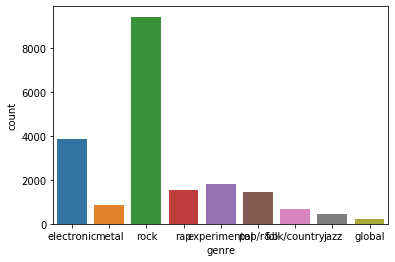

In [6]:
#countplot to see distribution of classes
sns.countplot(data['genre'])

In [0]:
data = data[(data['genre'].isna()==False) & (data['content'].isna()==False)]

Option 1: Downsampling

In [8]:
def sampling_k_elements(group, k=len(data[data['genre']=='global'])):
    return group.sample(k)

#Apply the function to all groups
balanced_df = data.groupby('genre').apply(sampling_k_elements).reset_index(drop=True)
balanced_df['genre'].value_counts()

electronic      219
experimental    219
global          219
pop/r&b         219
folk/country    219
metal           219
rap             219
jazz            219
rock            219
Name: genre, dtype: int64

In [9]:
balanced_df['category'] = balanced_df['genre'].astype("category").cat.codes
balanced_df.head()

,reviewid,content,genre,category
0,56,The first thing to note is that it's a wonderf...,electronic,0
1,9105,"Another month, another Ricardo Villalobos revi...",electronic,0
2,6696,Marco Haas is a man with a problem. On one han...,electronic,0
3,921,It was impossible to see what was going on to ...,electronic,0
4,14017,It took Eddy Current Suppression Ring just six...,electronic,0


In [0]:
np.random.seed(123)
balanced_df = balanced_df.iloc[np.random.permutation(len(balanced_df))]
cut1 = int(0.8 * len(balanced_df)) + 1
try:
    dropped_balanced_df = balanced_df.drop('genre', axis=1)
except:
    pass

df_train, df_valid = dropped_balanced_df[:cut1], dropped_balanced_df[cut1:]

In [0]:
category_numbers = dict(enumerate(balanced_df['genre'].astype("category").cat.categories))

In [0]:
data_lm = TextLMDataBunch.from_df(path="", train_df=df_train, valid_df = df_valid, text_cols="content", label_cols="category")

In [0]:
data_lm.save('pitchfork_data_lm.pkl')

In [0]:
data_lm = load_data("/content/drive/My Drive/Colab Notebooks/pitchfork_nlp/", 'pitchfork_data_lm.pkl')

Option 1.1 Retaining stopwords

In [0]:
learner = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


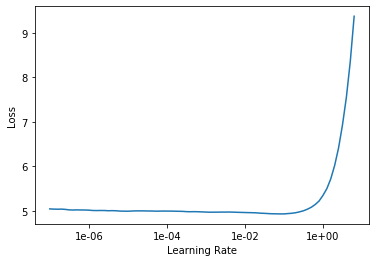

In [28]:
learner.lr_find(start_lr=1e-8, end_lr=1e2)
learner.recorder.plot()

In [29]:
learner.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.707302,4.537994,0.284959,03:06


In [30]:
learner.unfreeze()
learner.fit_one_cycle(cyc_len=5, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.397672,4.305531,0.301970,03:39
1,4.151989,4.159192,0.311772,03:39
2,3.751496,4.113461,0.318185,03:39
3,3.378191,4.150743,0.315834,03:39
4,3.114747,4.204424,0.312326,03:40


In [0]:
learner.save_encoder('pf_encoder')

In [0]:
data_clas = TextClasDataBunch.from_df(path="", train_df=df_train, valid_df = df_valid, vocab=data_lm.train_ds.vocab, text_cols="content",label_cols="category", bs=32)

In [0]:
clas = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
clas.load_encoder('pf_encoder')
clas.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


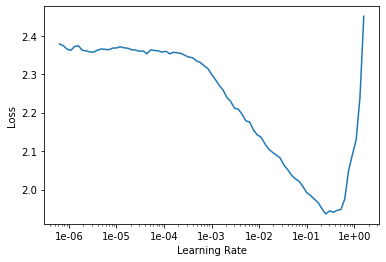

In [35]:
clas.lr_find()
clas.recorder.plot()

In [36]:
clas.fit_one_cycle(5, 1.7e-02)

epoch,train_loss,valid_loss,accuracy,time
0,1.717173,1.536140,0.487310,01:47
1,1.547273,1.455586,0.472081,01:42
2,1.433329,1.468403,0.517766,01:43
3,1.300088,1.445663,0.522843,01:45
4,1.185138,1.413141,0.527919,01:39


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-04
Min loss divided by 10: 9.12E-08


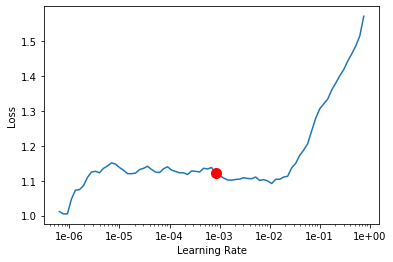

In [37]:
clas.freeze_to(-2)
clas.lr_find()
clas.recorder.plot(suggestion=True)

In [38]:
clas.fit_one_cycle(5, 1e-03, moms=(0.9,0.8))

epoch,train_loss,valid_loss,accuracy,time
0,1.116145,1.397950,0.500000,01:53
1,1.108716,1.396877,0.540609,01:56
2,1.065709,1.369270,0.530457,01:56
3,0.985223,1.385682,0.532995,02:03
4,0.948460,1.388660,0.527919,02:02


In [0]:
clas.save_encoder('freeze_2_encoder')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06
Min loss divided by 10: 6.31E-08


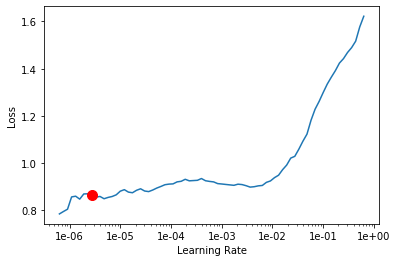

In [40]:
clas.freeze_to(-3)
clas.lr_find()
clas.recorder.plot(suggestion=True)

In [41]:
clas.fit_one_cycle(5, 3e-04, moms=(0.95,0.85))

epoch,train_loss,valid_loss,accuracy,time
0,0.878756,1.372250,0.540609,02:48
1,0.882553,1.370755,0.538071,02:53
2,0.884411,1.388070,0.543147,02:54
3,0.816943,1.386186,0.543147,02:49
4,0.784587,1.401024,0.545685,02:49


In [0]:
clas.save_encoder('freeze_3_encoder')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 5.75E-07


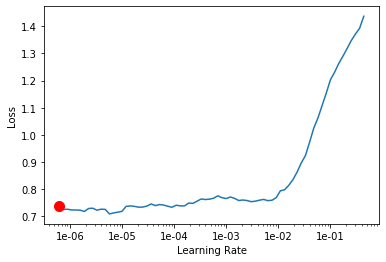

In [43]:
clas.unfreeze()
clas.lr_find()
clas.recorder.plot(suggestion=True)

In [44]:
clas.fit_one_cycle(5, slice(1e-05, 1e-03), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.780374,1.417831,0.515228,03:39
1,0.747642,1.519673,0.517766,03:24
2,0.722448,1.501208,0.530457,03:36
3,0.674269,1.490599,0.520305,03:28
4,0.632657,1.482010,0.530457,03:30
